In [1]:
import numpy as np
import pandas as pd
import folium
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import math

In [2]:
df = pd.read_csv('geo_locations_astana_hackathon')
df

,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.095460,71.427530,350.531020,0.206810,13.601680
1,1259981924615926140,51.098200,71.412950,348.801610,0.000000,265.677000
2,1259981924615926140,51.098460,71.412120,349.273880,4.345010,307.245300
3,7180852955221959108,51.089779,71.428469,314.000000,14.326102,192.123672
4,-6683155579225977143,51.088782,71.417462,325.300018,0.000602,0.000000
...,...,...,...,...,...,...
1262682,-4159094440281962734,51.095327,71.409942,328.400024,0.306837,286.840027
1262683,-4159094440281962734,51.095346,71.410199,328.400024,0.760408,263.180573
1262684,-4159094440281962734,51.095343,71.410272,328.400024,1.768341,89.564423
1262685,-4159094440281962734,51.095339,71.410246,328.400024,0.288987,211.242523


In [4]:
cur_df = df[df['randomized_id'] == 7637058049336049989]
cur_df

,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.09546,71.42753,350.53102,0.20681,13.60168
76,7637058049336049989,51.09564,71.42660,350.69790,10.36974,9.76439
77,7637058049336049989,51.09735,71.41442,351.14529,20.09926,9.76439
78,7637058049336049989,51.09708,71.41663,349.81716,17.89744,9.76439
7911,7637058049336049989,51.10063,71.41212,349.64070,9.36007,98.11707
...,...,...,...,...,...,...
1192619,7637058049336049989,51.08725,71.40183,350.05065,10.77340,192.11617
1192620,7637058049336049989,51.08472,71.40094,350.66176,17.62300,278.63144
1192621,7637058049336049989,51.09871,71.40588,350.18351,10.88258,192.11617
1192622,7637058049336049989,51.09018,71.40278,349.45085,13.13836,192.11617


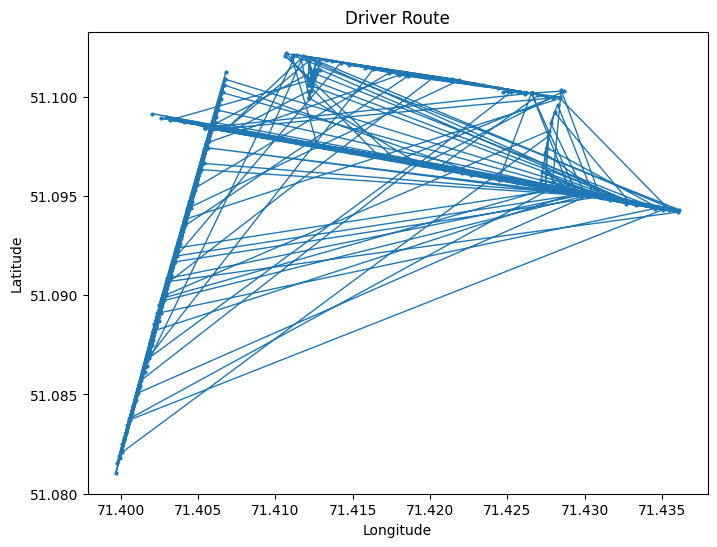

In [6]:
plt.figure(figsize=(8,6))
plt.plot(cur_df["lng"], cur_df["lat"], marker='o', markersize=2, linewidth=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Driver Route")
plt.show()

In [21]:
EARTH_R = 6371008.8
ASTANA_LAT0 = 51.17

# ---------- geo helpers ----------
def latlon_to_xy_m(lat, lon, lat0=ASTANA_LAT0):
    lat = np.asarray(lat); lon = np.asarray(lon)
    m_per_deg_lat = 111_132.92
    m_per_deg_lon = 111_412.84 * np.cos(np.deg2rad(lat0))
    x = (lon - np.mean(lon)) * m_per_deg_lon
    y = (lat - np.mean(lat)) * m_per_deg_lat
    return x, y

def haversine_m(lat1, lon1, lat2, lon2):
    lat1 = np.deg2rad(lat1); lat2 = np.deg2rad(lat2)
    dlat = lat2 - lat1
    dlon = np.deg2rad(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * EARTH_R * np.arcsin(np.sqrt(a))

def bearing_deg(lat1, lon1, lat2, lon2):
    φ1, φ2 = np.deg2rad(lat1), np.deg2rad(lat2)
    Δλ = np.deg2rad(lon2 - lon1)
    y = np.sin(Δλ) * np.cos(φ2)
    x = np.cos(φ1)*np.cos(φ2) * np.cos(Δλ) + np.sin(φ1)*np.sin(φ2)
    return (np.rad2deg(np.arctan2(y, x)) + 360) % 360

def angdiff_deg(a, b):
    # minimal absolute difference in degrees
    return np.abs((a - b + 180) % 360 - 180)

# ---------- circular smoothing for azimuth ----------
def circ_mean_deg(arr_deg):
    arr = np.deg2rad(arr_deg)
    s = np.nanmean(np.sin(arr))
    c = np.nanmean(np.cos(arr))
    if np.isnan(s) or np.isnan(c):
        return np.nan
    ang = np.arctan2(s, c)
    return (np.rad2deg(ang) + 360) % 360

def circ_movavg_deg(azm, win=7):
    # odd window
    if win % 2 == 0: win += 1
    k = win // 2
    out = np.full_like(azm, np.nan, dtype=float)
    for i in range(len(azm)):
        lo = max(0, i - k)
        hi = min(len(azm), i + k + 1)
        out[i] = circ_mean_deg(azm[lo:hi])
    return out

# ---------- PCA-ish start ----------
def pca_start_idx(xy):
    X = xy - xy.mean(axis=0, keepdims=True)
    _, _, vt = np.linalg.svd(X, full_matrices=False)
    v = vt[0]
    proj = X @ v
    return int(np.argmin(proj))

# ---------- azimuth-aware ordering ----------
def order_by_heading(lat, lon, azm,
                     k_nn=25,
                     lambda_bearing=10.0,   # penalize mismatch vs current azm (m per rad)
                     lambda_turn=6.0,       # penalize sharp change vs last step bearing
                     lambda_azm_cand=3.0,   # penalize mismatch vs candidate's own azm
                     angle_gate_deg=110,    # hard gate; relax if no candidates
                     uturn_boost_deg=150,   # extra penalty for near-UTurn
                     uturn_penalty_m=50.0): # meters added for near-UTurn
    n = len(lat)
    xy = np.c_[*latlon_to_xy_m(lat, lon)]
    # Smooth azimuth for stability
    azm_s = circ_movavg_deg(azm, win=9) if azm is not None else None

    start = pca_start_idx(xy)
    unused = np.ones(n, dtype=bool); unused[start] = False
    order = [start]

    # Precompute pairwise distances in xy space on the fly via norms
    last_bear = azm_s[start] if azm_s is not None and not np.isnan(azm_s[start]) else None

    while unused.any():
        cur = order[-1]
        cand = np.where(unused)[0]
        # pick k nearest by Euclidean for speed
        dxy = np.hypot(xy[cand,0] - xy[cur,0], xy[cand,1] - xy[cur,1])
        if len(cand) > k_nn:
            idx = np.argpartition(dxy, k_nn)[:k_nn]
            cand = cand[idx]
            dxy = dxy[idx]

        # bearings and angle-based costs
        br = bearing_deg(lat[cur], lon[cur], lat[cand], lon[cand])

        # hard gate by current azm if present
        cur_azm = azm_s[cur] if azm_s is not None else np.nan
        gate = angle_gate_deg
        mask = np.ones_like(cand, dtype=bool)
        if not np.isnan(cur_azm):
            ang_cur = angdiff_deg(cur_azm, br)
            mask = (ang_cur <= gate)
            # if no candidates pass, relax gate progressively
            relaxes = 0
            while not mask.any() and gate < 180:
                gate = min(180, int(gate * 1.3))
                mask = (ang_cur <= gate)
                relaxes += 1
        cand2 = cand[mask]; dxy2 = dxy[mask]
        if len(cand2) == 0:
            # fallback: pure nearest neighbor
            j = cand[int(np.argmin(dxy))]
            order.append(j); unused[j] = False
            last_bear = bearing_deg(lat[cur], lon[cur], lat[j], lon[j])
            continue

        br2 = bearing_deg(lat[cur], lon[cur], lat[cand2], lon[cand2])

        cost = dxy2.copy()

        # mismatch vs current azm
        if not np.isnan(cur_azm):
            diff1 = np.deg2rad(angdiff_deg(cur_azm, br2))
            cost = cost + lambda_bearing * diff1

        # smoothness vs previous step bearing
        if last_bear is not None:
            diff2 = np.deg2rad(angdiff_deg(last_bear, br2))
            cost = cost + lambda_turn * diff2
            # U-turn boost
            cost = cost + (uturn_penalty_m * (angdiff_deg(last_bear, br2) >= uturn_boost_deg))

        # mismatch vs candidate azm (if candidate has azm)
        if azm_s is not None:
            cand_azm = azm_s[cand2]
            diff3 = np.deg2rad(angdiff_deg(cand_azm, br2))
            # where cand_azm is nan, set penalty 0
            diff3 = np.where(np.isnan(cand_azm), 0.0, diff3)
            cost = cost + lambda_azm_cand * diff3

        # pick min cost
        j = cand2[int(np.argmin(cost))]
        order.append(j); unused[j] = False
        last_bear = bearing_deg(lat[cur], lon[cur], lat[j], lon[j])

    return order

def split_segments(order, lat, lon, jump_thr_m=250.0):
    seg = np.zeros(len(order), dtype=int)
    curseg = 0
    for t in range(1, len(order)):
        i, j = order[t-1], order[t]
        d = haversine_m(lat[i], lon[i], lat[j], lon[j])
        if d > jump_thr_m:
            curseg += 1
        seg[t] = curseg
    return seg

def order_trip_azm_aware(trip: pd.DataFrame,
                         k_nn=15,
                         lambda_bearing=10.0,
                         lambda_turn=6.0,
                         lambda_azm_cand=3.0,
                         angle_gate_deg=110,
                         jump_thr_m=250.0) -> pd.DataFrame:
    t = trip.copy()
    t["lat"] = t["lat"].astype(float)
    t["lng"] = t["lng"].astype(float)
    if "azm" in t.columns:
        t["azm"] = pd.to_numeric(t["azm"], errors="coerce")
    else:
        t["azm"] = np.nan

    lat = t["lat"].to_numpy(); lon = t["lng"].to_numpy(); azm = t["azm"].to_numpy()

    order = order_by_heading(
        lat, lon, azm,
        k_nn=k_nn,
        lambda_bearing=lambda_bearing,
        lambda_turn=lambda_turn,
        lambda_azm_cand=lambda_azm_cand,
        angle_gate_deg=angle_gate_deg
    )
    seg_id = split_segments(order, lat, lon, jump_thr_m=jump_thr_m)

    out = t.iloc[order].copy()
    out["seq"] = np.arange(len(out))
    out["segment_id"] = seg_id
    step = np.zeros(len(out))
    step[1:] = haversine_m(out["lat"].shift(1).values[1:],
                           out["lng"].shift(1).values[1:],
                           out["lat"].values[1:],
                           out["lng"].values[1:])
    out["step_m"] = step
    return out

In [8]:
trip_ord = order_trip_azm_aware(
    cur_df,
    k_nn=35,               # consider a few more neighbors in dense areas
    lambda_bearing=12.0,   # stronger pull to follow current azimuth
    lambda_turn=8.0,       # smoother path / penalize sharp turns
    lambda_azm_cand=4.0,   # prefer candidates whose own azm aligns with link
    angle_gate_deg=100,    # disallow crazy directions unless no options
    jump_thr_m=250.0
)

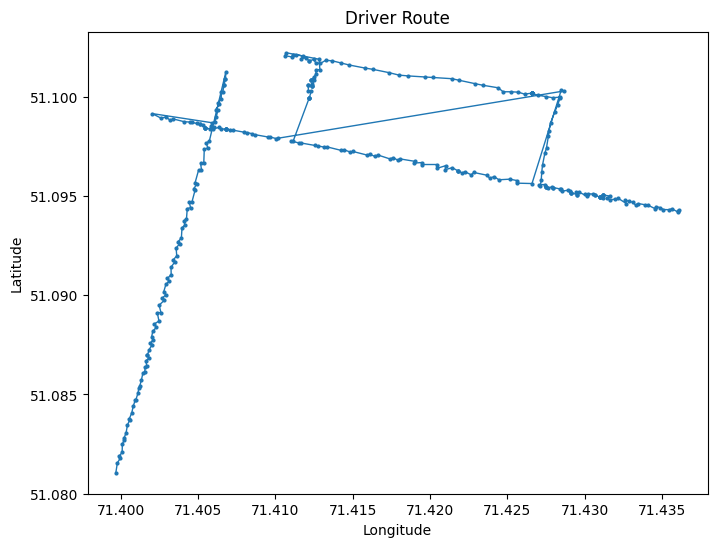

In [9]:
plt.figure(figsize=(8,6))
plt.plot(trip_ord["lng"], trip_ord["lat"], marker='o', markersize=2, linewidth=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Driver Route")
plt.show()

In [70]:
clear_trip = clean_segment(trip_ord)
clear_trip

,randomized_id,lat,lng,alt,spd,azm,seq,segment_id,step_m
0,7637058049336049989,51.09431,71.43614,351.05533,17.72026,8.83589,0,0,0.000000
1,7637058049336049989,51.09463,71.43348,351.04130,15.16673,281.55255,11,0,30.761081
2,7637058049336049989,51.09506,71.43120,348.06514,8.66960,357.59912,22,0,30.538931
3,7637058049336049989,51.09506,71.43120,348.06514,8.66960,357.59921,23,0,0.000000
4,7637058049336049989,51.09506,71.43120,348.06514,8.66960,13.79934,24,0,0.000000
...,...,...,...,...,...,...,...,...,...
121,7637058049336049989,51.08250,71.40010,350.46476,18.26325,283.94101,310,5,25.054529
122,7637058049336049989,51.08208,71.40009,350.60639,18.41262,280.29724,311,5,46.707157
123,7637058049336049989,51.08187,71.39988,350.72256,18.19787,283.94101,312,5,27.576346
124,7637058049336049989,51.08178,71.39997,350.41215,20.23713,280.29724,313,5,11.818445


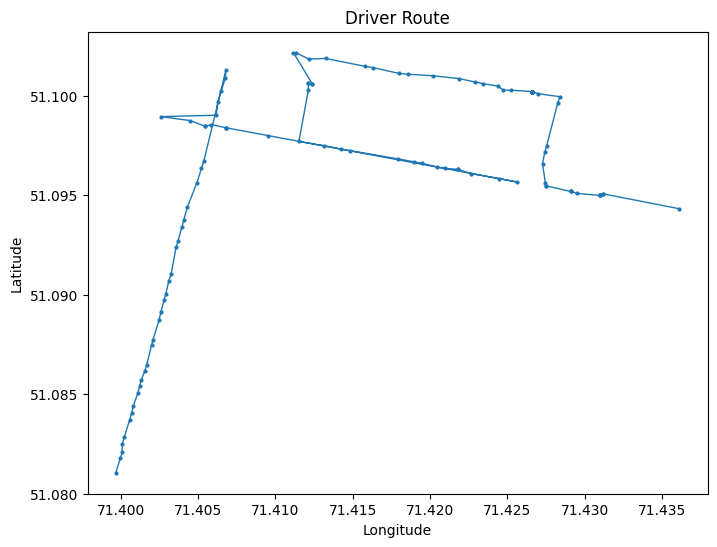

In [17]:
plt.figure(figsize=(8,6))
plt.plot(clear_trip["lng"], clear_trip["lat"], marker='o', markersize=2, linewidth=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Driver Route")
plt.show()

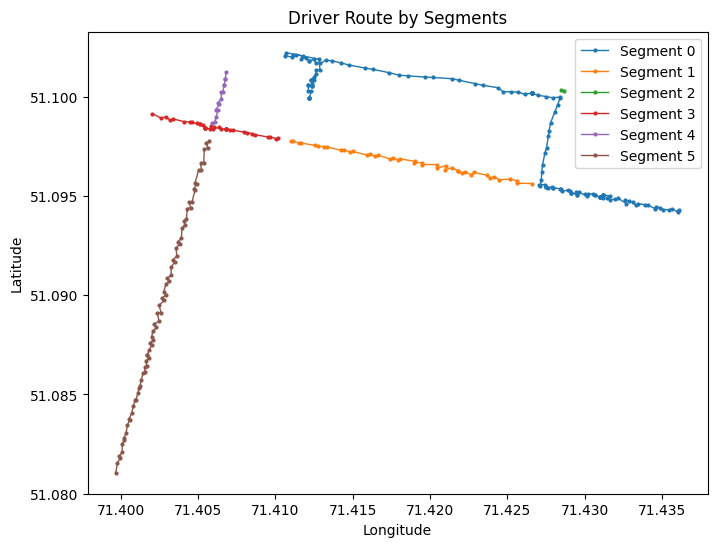

In [18]:
plt.figure(figsize=(8,6))

# group by segment_id and plot each with a different color
for seg_id, seg_df in trip_ord.groupby("segment_id"):
    plt.plot(seg_df["lng"], seg_df["lat"],
             marker='o', markersize=2, linewidth=1,
             label=f"Segment {seg_id}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Driver Route by Segments")
plt.legend()
plt.show()


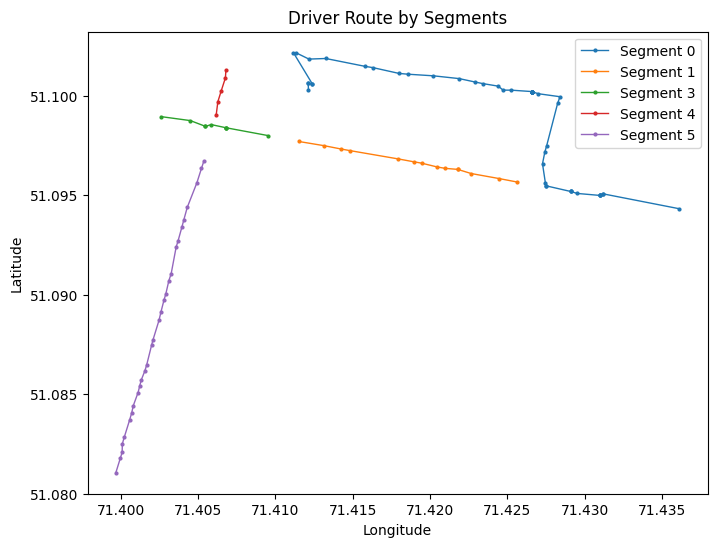

In [19]:
plt.figure(figsize=(8,6))

# group by segment_id and plot each with a different color
for seg_id, seg_df in clear_trip.groupby("segment_id"):
    plt.plot(seg_df["lng"], seg_df["lat"],
             marker='o', markersize=2, linewidth=1,
             label=f"Segment {seg_id}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Driver Route by Segments")
plt.legend()
plt.show()


In [17]:
trip_ord

,randomized_id,lat,lng,alt,spd,azm,seq,segment_id,step_m
15765,7637058049336049989,51.09431,71.43614,351.05533,17.72026,8.83589,0,0,0.000000
590786,7637058049336049989,51.09425,71.43602,350.79178,10.89636,281.55255,1,0,10.711652
48480,7637058049336049989,51.09420,71.43604,350.28236,17.61895,104.22897,2,0,5.732508
1137906,7637058049336049989,51.09437,71.43565,350.87210,17.76816,8.83589,3,0,33.152842
731056,7637058049336049989,51.09432,71.43548,350.99119,12.69261,281.55255,4,0,13.109303
...,...,...,...,...,...,...,...,...,...
874867,7637058049336049989,51.08208,71.40009,350.60639,18.41262,280.29724,311,5,46.707157
1052817,7637058049336049989,51.08187,71.39988,350.72256,18.19787,283.94101,312,5,27.576346
33439,7637058049336049989,51.08178,71.39997,350.41215,20.23713,280.29724,313,5,11.818445
491761,7637058049336049989,51.08155,71.39978,350.98124,18.76856,283.94101,314,5,28.813664


In [18]:
prev_lat, prev_lng = trip_ord.iloc[0].lat, trip_ord.iloc[0].lng
for _, row in trip_ord.iterrows():
    if abs(row.lat - prev_lat) > 0.01 or abs(row.lng - prev_lng) > 0.01:
        print(row.lat, row.lng)
        continue
    prev_lat, prev_lng = row.lat, row.lng
    

51.09792 71.41014
51.09791 71.41005
51.09799 71.40965
51.09799 71.40951
51.09811 71.40865
51.09816 71.40847
51.09821 71.40818
51.09823 71.40798
51.09833 71.40728
51.09833 71.40709
51.09838 71.40681
51.09838 71.40681
51.09838 71.40681
51.09838 71.40681
51.09838 71.40681
51.0984 71.4065
51.09847 71.40635
51.0984 71.40597
51.09847 71.40602
51.09854 71.40585
51.09839 71.40577
51.09845 71.40548
51.09845 71.40548
51.09845 71.40548
51.09845 71.40548
51.0986 71.40535
51.09862 71.40512
51.09862 71.40512
51.09867 71.40493
51.09872 71.40463
51.09874 71.4045
51.09876 71.4041
51.0989 71.40339
51.09884 71.40318
51.099 71.40293
51.09894 71.4026
51.09917 71.40203
51.09871 71.40588
51.09872 71.40607
51.09901 71.40617
51.09934 71.40629
51.09936 71.40613
51.09963 71.40638
51.09969 71.40628
51.09993 71.4065
51.10024 71.4065
51.10028 71.4066
51.10059 71.40668
51.10062 71.40668
51.1009 71.40676
51.10089 71.40677
51.10128 71.4068
51.09779 71.40573
51.09768 71.40554
51.09744 71.40562
51.09736 71.4054
51.0967 

In [19]:
trip_ord.iloc[0].lat

51.09431

In [10]:

# ---- Helpers ----
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)
    a = math.sin(Δφ/2.0)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(Δλ/2.0)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

# ---- 1) Per-point cleaning ----
def clean_segment(df_seg, speed_col='spd', lat_col='lat', lng_col='lng',
                  max_speed_kmh=180.0, max_step_m=100.0, azm_col='azm',
                  azm_jump_thresh=50.0, min_points=10):
    """
    Remove obvious outliers in a single segment dataframe (ordered).
    Returns cleaned df (reset index). Thresholds are tunable.
    """
    df = df_seg.copy().reset_index(drop=True)

    # normalize speed -> m/s if likely in km/h (detect heuristics)
    # If values look > 50 typically, assume km/h
    if df[speed_col].median() > 50:
        df[speed_col] = df[speed_col] * (1000.0/3600.0)  # km/h -> m/s

    # drop negative or extremely high speed
    max_speed_ms = max_speed_kmh * (1000.0/3600.0)
    mask = (df[speed_col] >= 0.0) & (df[speed_col] <= max_speed_ms)
    df = df[mask].reset_index(drop=True)

    # drop huge jumps between consecutive points (likely teleport)
    df = df[df['step_m'] <= max_step_m].reset_index(drop=True)
    if len(df) < min_points:
        return pd.DataFrame(columns=df_seg.columns)

    # detect azimuth flip while moving: large change but speed remains high -> drop point
    if azm_col in df.columns:
        bad_idx = []
        for i in range(1, len(df)):
            if df.loc[i-1, speed_col] > 1.0 and df.loc[i, speed_col] > 1.0:
                d_azm = abs((df.loc[i, azm_col] - df.loc[i-1, azm_col]) % 360)
                d_azm = min(d_azm, 360 - d_azm)
                if d_azm > azm_jump_thresh:
                    bad_idx.append(i)
        if bad_idx:
            df = df.drop(bad_idx).reset_index(drop=True)

    return df.reset_index(drop=True)

In [11]:


# ---- 5) create sequences and mapping for cell embedding ----
def build_cell_mapping(all_segments, cell_col='cell_id'):
    cells = set()
    for seg in all_segments:
        if cell_col in seg.columns:
            cells.update(seg[cell_col].unique())
    cells = sorted(list(cells))
    cell2idx = {c:i for i,c in enumerate(cells)}
    return cell2idx

def prepare_segment_for_model(df_seg, cell2idx=None, speed_col='speed', azm_col='azm'):
    """
    Compute features for one segment used by model:
      - cell_idx sequence (list of ints)
      - numeric features: speed, sin(azm), cos(azm), delta_speed, accel, cum_dist
    """
    df = df_seg.reset_index(drop=True).copy()
    if 'step_m' not in df.columns:
        # compute step_m if missing
        dists = [0.0]
        for i in range(1, len(df)):
            dists.append(haversine_m(df.loc[i-1,'lat'], df.loc[i-1,'lng'], df.loc[i,'lat'], df.loc[i,'lng']))
        df['step_m'] = dists
    # estimate dt from speed / distance safely
    eps = 0.5
    dt = [1.0]
    for i in range(1, len(df)):
        s = max(df.loc[i, speed_col], eps)
        est = df.loc[i, 'step_m'] / s if s > 0 else 1.0
        dt.append(max(0.05, min(est, 300.0)))
    df['est_dt'] = dt

    df['delta_speed'] = df[speed_col].diff().fillna(0.0)
    df['accel'] = df['delta_speed'] / df['est_dt'].replace(0,1.0)
    rad = np.deg2rad(df[azm_col].fillna(0.0).values)
    df['azm_sin'] = np.sin(rad)
    df['azm_cos'] = np.cos(rad)
    df['cum_dist'] = df['step_m'].cumsum()

    if cell2idx is not None and 'cell_id' in df.columns:
        cell_seq = [cell2idx[c] for c in df['cell_id'].values]
    else:
        cell_seq = [0]*len(df)  # fallback

    # numeric features per timestep
    num_feats = df[[speed_col, 'delta_speed', 'accel', 'azm_sin', 'azm_cos', 'cum_dist']].values.astype(float)
    return np.array(cell_seq, dtype=int), num_feats, df[speed_col].values.astype(float)

In [12]:
def add_acceleration_to_segment(df_seg, speed_col='spd', lat_col='lat', lng_col='lng',
                                default_dt=1.0, eps=0.5, inplace=False):
    """
    Add columns ['est_dt', 'delta_speed', 'accel'] to df_seg and return it.
    - If 'est_dt' already exists, it is used.
    - Otherwise we estimate est_dt per step as step_m / max(speed, eps) with fallback default_dt.
    - speed units: if median(speed) > 50 we assume km/h and convert to m/s.
    """
    if not inplace:
        df = df_seg.copy().reset_index(drop=True)
    else:
        df = df_seg.reset_index(drop=True)

    # ensure speed column exists
    if speed_col not in df.columns:
        # create small speed to avoid divide by zero
        df[speed_col] = 1.0

    # detect likely km/h and convert to m/s
    if df[speed_col].notna().any():
        med = float(np.nanmedian(df[speed_col].values))
    else:
        med = 0.0
    if med > 50:  # heuristic: values >50 likely in km/h
        df[speed_col] = df[speed_col] * (1000.0 / 3600.0)

    # ensure step_m exists (compute if absent)
    if 'step_m' not in df.columns:
        step_m = [0.0]
        for i in range(1, len(df)):
            step_m.append(haversine_m(df.loc[i-1, lat_col], df.loc[i-1, lng_col],
                                      df.loc[i, lat_col], df.loc[i, lng_col]))
        df['step_m'] = step_m

    # if est_dt exists, use it; else estimate
    if 'est_dt' not in df.columns:
        est_dt = [default_dt]
        for i in range(1, len(df)):
            spd = float(df.loc[i, speed_col])
            spd = max(spd, eps)
            # avoid crazy est_dt values: clamp within reasonable bounds
            raw = df.loc[i, 'step_m'] / spd if spd > 0 else default_dt
            if np.isnan(raw) or raw <= 0 or raw > 3600:
                raw = default_dt
            est_dt.append(raw)
        df['est_dt'] = est_dt
    else:
        # clean est_dt: replace zeros/nans with default
        df['est_dt'] = df['est_dt'].fillna(default_dt).replace(0, default_dt)

    # compute delta_speed (current - prev)
    df['delta_speed'] = df[speed_col].diff().fillna(0.0)

    # acceleration = delta_speed / est_dt (first row -> 0)
    # protect division by zero
    df['accel'] = df['delta_speed'] / df['est_dt'].replace(0, default_dt)

    # final safety: fill nans with 0
    df['accel'] = df['accel'].fillna(0.0)

    return df



In [13]:
cur_df_acc = add_acceleration_to_segment(trip_ord)
cur_df_acc

,randomized_id,lat,lng,alt,spd,azm,seq,segment_id,step_m,est_dt,delta_speed,accel
0,7637058049336049989,51.09431,71.43614,351.05533,17.72026,8.83589,0,0,0.000000,1.000000,0.00000,0.000000
1,7637058049336049989,51.09425,71.43602,350.79178,10.89636,281.55255,1,0,10.711652,0.983049,-6.82390,-6.941569
2,7637058049336049989,51.09420,71.43604,350.28236,17.61895,104.22897,2,0,5.732508,0.325360,6.72259,20.661984
3,7637058049336049989,51.09437,71.43565,350.87210,17.76816,8.83589,3,0,33.152842,1.865857,0.14921,0.079969
4,7637058049336049989,51.09432,71.43548,350.99119,12.69261,281.55255,4,0,13.109303,1.032830,-5.07555,-4.914218
...,...,...,...,...,...,...,...,...,...,...,...,...
311,7637058049336049989,51.08208,71.40009,350.60639,18.41262,280.29724,311,5,46.707157,2.536693,0.14937,0.058884
312,7637058049336049989,51.08187,71.39988,350.72256,18.19787,283.94101,312,5,27.576346,1.515361,-0.21475,-0.141715
313,7637058049336049989,51.08178,71.39997,350.41215,20.23713,280.29724,313,5,11.818445,0.583998,2.03926,3.491895
314,7637058049336049989,51.08155,71.39978,350.98124,18.76856,283.94101,314,5,28.813664,1.535209,-1.46857,-0.956593


In [14]:
mask = cur_df_acc['accel'] < 0
mask

0      False
1       True
2      False
3      False
4       True
       ...  
311    False
312     True
313    False
314     True
315    False
Name: accel, Length: 316, dtype: bool

In [15]:
cur_df_acc = cur_df_acc[~mask]
cur_df_acc

,randomized_id,lat,lng,alt,spd,azm,seq,segment_id,step_m,est_dt,delta_speed,accel
0,7637058049336049989,51.09431,71.43614,351.05533,17.72026,8.83589,0,0,0.000000,1.000000,0.00000,0.000000
2,7637058049336049989,51.09420,71.43604,350.28236,17.61895,104.22897,2,0,5.732508,0.325360,6.72259,20.661984
3,7637058049336049989,51.09437,71.43565,350.87210,17.76816,8.83589,3,0,33.152842,1.865857,0.14921,0.079969
5,7637058049336049989,51.09433,71.43509,350.17514,18.83332,104.22897,5,0,27.258329,1.447346,6.14071,4.242738
7,7637058049336049989,51.09448,71.43461,350.29166,18.30985,8.83589,7,0,21.987096,1.200834,4.24487,3.534934
...,...,...,...,...,...,...,...,...,...,...,...,...
308,7637058049336049989,51.08282,71.40022,350.52276,18.16327,283.94101,308,5,26.913495,1.481754,0.37240,0.251324
310,7637058049336049989,51.08250,71.40010,350.46476,18.26325,283.94101,310,5,25.054529,1.371855,0.78288,0.570673
311,7637058049336049989,51.08208,71.40009,350.60639,18.41262,280.29724,311,5,46.707157,2.536693,0.14937,0.058884
313,7637058049336049989,51.08178,71.39997,350.41215,20.23713,280.29724,313,5,11.818445,0.583998,2.03926,3.491895


In [16]:
clear_trip = clean_segment(cur_df_acc)
clear_trip

,randomized_id,lat,lng,alt,spd,azm,seq,segment_id,step_m,est_dt,delta_speed,accel
0,7637058049336049989,51.09431,71.43614,351.05533,17.72026,8.83589,0,0,0.000000,1.000000,0.00000,0.000000
1,7637058049336049989,51.09506,71.43120,348.06514,8.66960,13.79934,24,0,0.000000,1.000000,0.00000,0.000000
2,7637058049336049989,51.09506,71.43120,348.06514,8.66960,13.79934,25,0,0.000000,1.000000,0.00000,0.000000
3,7637058049336049989,51.09498,71.43101,349.02705,9.24955,281.64310,27,0,0.000000,1.000000,0.00000,0.000000
4,7637058049336049989,51.09498,71.43101,349.02705,9.24955,275.96481,28,0,0.000000,1.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
104,7637058049336049989,51.08282,71.40022,350.52276,18.16327,283.94101,308,5,26.913495,1.481754,0.37240,0.251324
105,7637058049336049989,51.08250,71.40010,350.46476,18.26325,283.94101,310,5,25.054529,1.371855,0.78288,0.570673
106,7637058049336049989,51.08208,71.40009,350.60639,18.41262,280.29724,311,5,46.707157,2.536693,0.14937,0.058884
107,7637058049336049989,51.08178,71.39997,350.41215,20.23713,280.29724,313,5,11.818445,0.583998,2.03926,3.491895


In [50]:
def segments_to_arrays(df,
                       randomized_id = 'randomized_id',
                       segment_col='segment_id',
                       lat_col='lat',
                       lng_col='lng',
                       spd_col='spd',
                       azm_col='azm',
                       acc_col = 'accel',
                       min_points=1,
                       order_col=None):

    records = []
    for seg_id, g in df.groupby(segment_col):
        g2 = g.copy()
        # optional ordering inside segment
        arr = g2[[randomized_id, lat_col, lng_col, spd_col, azm_col, acc_col]].to_numpy(dtype=float)
        if arr.shape[0] < min_points:
            continue
        records.append({ 'randomized_id': randomized_id, 'segment_id': seg_id, 'array': arr, 'n_points': arr.shape[0]})

    if len(records) == 0:
        df_segments = pd.DataFrame(columns=['randomized_id','segment_id', 'array', 'n_points'])
        df_counts = pd.DataFrame(columns=['segment_id', 'n_points'])
        return df_segments, df_counts

    df_segments = pd.DataFrame.from_records(records, columns=['randomized_id', 'segment_id', 'array', 'n_points'])
    df_counts = df_segments[['segment_id', 'n_points']].copy().reset_index(drop=True)
    return df_segments, df_counts

In [53]:
from tqdm import tqdm

new_df_list = []
i = 0
for id in tqdm(df['randomized_id'].unique()):
    new_df = df[df['randomized_id'] == id].copy()
    trip_ord = order_trip_azm_aware(
        new_df,
        k_nn=35,               # consider a few more neighbors in dense areas
        lambda_bearing=12.0,   # stronger pull to follow current azimuth
        lambda_turn=8.0,       # smoother path / penalize sharp turns
        lambda_azm_cand=4.0,   # prefer candidates whose own azm aligns with link
        angle_gate_deg=100,    # disallow crazy directions unless no options
        jump_thr_m=250.0
    )
    clear_trip = clean_segment(trip_ord)
    cur_df_acc = add_acceleration_to_segment(clear_trip)
    mask = cur_df_acc['accel'] < 0
    cur_df_acc = cur_df_acc[~mask]
    # print(cur_df_acc)
    df_segments, _ = segments_to_arrays(cur_df_acc)
    
    mask = df_segments.n_points < 10
    df_segments = df_segments[~mask]
    print(df_segments)
    break
    new_df_list.append(df_segments)
    

  0%|                                                  | 0/6805 [00:00<?, ?it/s]

   randomized_id  segment_id  \
0  randomized_id           0   
4  randomized_id           5   

                                               array  n_points  
0  [[7.63705804933605e+18, 51.09431, 71.43614, 17...        55  
4  [[7.63705804933605e+18, 51.09768, 71.40554, 18...        17  


In [52]:
new_df = pd.concat(new_df_list, ignore_index=True)
new_df

,randomized_id,segment_id,array,n_points
0,randomized_id,0,"[[7.63705804933605e+18, 51.09431, 71.43614, 17...",55
1,randomized_id,5,"[[7.63705804933605e+18, 51.09768, 71.40554, 18...",17
2,randomized_id,0,"[[1.259981924615926e+18, 51.10222, 71.41099, 1...",50
3,randomized_id,1,"[[1.259981924615926e+18, 51.0942, 71.42638, 12...",47
4,randomized_id,0,"[[7.180852955221959e+18, 51.0943876, 71.436062...",63
...,...,...,...,...
138,randomized_id,2,"[[2.086289153677788e+18, 51.09438, 71.43449, 1...",18
139,randomized_id,3,"[[2.086289153677788e+18, 51.09005, 71.42507, 1...",28
140,randomized_id,4,"[[2.086289153677788e+18, 51.07786, 71.40624, 1...",11
141,randomized_id,5,"[[2.086289153677788e+18, 51.08973, 71.42851, 1...",34
